In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Generate test data

<Container object of 3 artists>

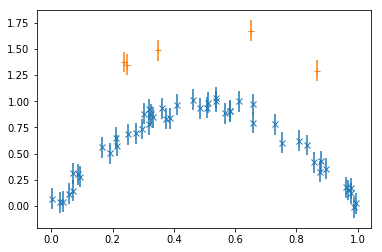

In [2]:
x_ = np.r_[0:1:1001j]

n1 = 50
x1 = np.sort(np.random.rand(n1))
n2 = 5
x2 = np.sort(np.random.rand(n2))
noise_ampl = 0.2

def f1(x):
    return np.sin(np.pi*x)

def f2(x):
    return f1(x) + 0.5 * (x+1)

y1 = f1(x1) + np.random.uniform(-noise_ampl/2, noise_ampl/2, size=n1)
err1 = np.full_like(y1, noise_ampl/2)
y2 = f2(x2) + np.random.uniform(-noise_ampl/2, noise_ampl/2, size=n2)
err2 = np.full_like(y2, noise_ampl/2)

plt.errorbar(x1, y1, err1, marker='x', ls='')
plt.errorbar(x2, y2, err2, marker='+', ls='')

# Train Gaussian process

## Copy-paste from https://github.com/rmjarvis/Piff/blob/4072b3567a2f9a7213283f774bc5497259dbe0c5/piff/kernel.py

In [3]:
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel
from sklearn.gaussian_process.kernels import Hyperparameter
from sklearn.gaussian_process.kernels import _check_length_scale

class AnisotropicRBF(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    """ A GaussianProcessRegressor Kernel representing a radial basis function (essentially a
    squared exponential or Gaussian) but with arbitrary anisotropic covariance.
    While the parameter for this kernel, an inverse covariance matrix, can be specified directly
    with the `invLam` kwarg, it may be more convenient to instead specify a characteristic
    scale-length for each axis using the `scale_length` kwarg.  Note that a list or array is
    required so that the dimensionality of the kernel can be determined from its length.
    For optimization, it's necessary to reparameterize the inverse covariance matrix in such a way
    as to ensure that it's always positive definite.  To this end, we define `theta` (abbreviated
    `th` below) such that
    invLam = L * L.T
    L = [[exp(th[0])  0              0           ...    0                 0           ]
         [th[n]       exp(th[1])]    0           ...    0                 0           ]
         [th[n+1]     th[n+2]        exp(th[3])  ...    0                 0           ]
         [...         ...            ...         ...    ...               ...         ]
         [th[]        th[]           th[]        ...    exp(th[n-2])      0           ]
         [th[]        th[]           th[]        ...    th[n*(n+1)/2-1]   exp(th[n-1])]]
    I.e., the inverse covariance matrix is Cholesky-decomposed, exp(theta[0:n]) lie on the diagonal
    of the Cholesky matrix, and theta[n:n*(n+1)/2] lie in the lower triangular part of the Cholesky
    matrix.  This parameterization invertably maps all valid n x n covariance matrices to
    R^(n*(n+1)/2).  I.e., the range of each theta[i] is -inf...inf.
    :param  invLam:  Inverse covariance matrix of radial basis function.  Exactly one of invLam and
                     scale_length must be provided.
    :param  scale_length:  Axes-aligned scale lengths of the kernel.  len(scale_length) must be the
                     same as the dimensionality of the kernel, even if the scale length is the same
                     for each axis (i.e., even if the kernel is isotropic).  Exactly one of invLam
                     and scale_length must be provided.
    :param  bounds:  Optional keyword indicating fitting bounds on *theta*.  Can either be a
                     2-element iterable, which will be taken to be the min and max value for every
                     theta element, or an [ntheta, 2] array indicating bounds on each of ntheta
                     elements.
    """
    def __init__(self, invLam=None, scale_length=None, bounds=(-5,5)):
        if scale_length is not None:
            if invLam is not None:
                raise TypeError("Cannot set both invLam and scale_length in AnisotropicRBF.")
            invLam = np.diag(1./np.array(scale_length)**2)

        self.ndim = invLam.shape[0]
        self.ntheta = self.ndim*(self.ndim+1)//2
        self._d = np.diag_indices(self.ndim)
        self._t = np.tril_indices(self.ndim, -1)
        self.set_params(invLam)
        bounds = np.array(bounds)
        if bounds.ndim == 1:
            bounds = np.repeat(bounds[None, :], self.ntheta, axis=0)
        assert bounds.shape == (self.ntheta, 2)
        self._bounds = bounds

    def __call__(self, X, Y=None, eval_gradient=False):
        from scipy.spatial.distance import pdist, cdist, squareform
        X = np.atleast_2d(X)

        if Y is None:
            dists = pdist(X, metric='mahalanobis', VI=self.invLam)
            K = np.exp(-0.5 * dists**2)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Gradient can only be evaluated when Y is None.")
            dists = cdist(X, Y, metric='mahalanobis', VI=self.invLam)
            K = np.exp(-0.5 * dists**2)

        if eval_gradient:
            if self.hyperparameter_cholesky_factor.fixed:
                return K, np.empty((X.shape[0], X.shape[0], 0))
            else:
                # dK_pq/dth_k = -0.5 * K_pq *
                #               ((x_p_i-x_q_i) * dInvLam_ij/dth_k * (x_q_j - x_q_j))
                # dInvLam_ij/dth_k = dL_ij/dth_k * L_ij.T  +  L_ij * dL_ij.T/dth_k
                # dL_ij/dth_k is a matrix with all zeros except for one element.  That element is
                # L_ij if k indicates one of the theta parameters landing on the Cholesky diagonal,
                # and is 1.0 if k indicates one of the thetas in the lower triangular region.
                L_grad = np.zeros((self.ntheta, self.ndim, self.ndim), dtype=float)
                L_grad[(np.arange(self.ndim),)+self._d] = self._L[self._d]
                L_grad[(np.arange(self.ndim, self.ntheta),)+self._t] = 1.0

                half_invLam_grad = np.dot(L_grad, self._L.T)
                invLam_grad = half_invLam_grad + np.transpose(half_invLam_grad, (0, 2, 1))

                dX = X[:, np.newaxis, :] - X[np.newaxis, :, :]
                dist_grad = np.einsum("ijk,lkm,ijm->ijl", dX, invLam_grad, dX)
                K_gradient = -0.5 * K[:, :, np.newaxis] * dist_grad
                return K, K_gradient
        else:
            return K

    @property
    def hyperparameter_cholesky_factor(self):
        return Hyperparameter("CholeskyFactor", "numeric", (1e-5, 1e5), int(self.ntheta))

    def get_params(self, deep=True):
        return {"invLam":self.invLam}

    def set_params(self, invLam=None):
        if invLam is not None:
            self.invLam = invLam
            self._L = np.linalg.cholesky(self.invLam)
            self._theta = np.hstack([np.log(self._L[self._d]), self._L[self._t]])

    @property
    def theta(self):
        return self._theta

    @theta.setter
    def theta(self, theta):
        self._theta = theta
        self._L = np.zeros_like(self.invLam)
        self._L[np.diag_indices(self.ndim)] = np.exp(theta[:self.ndim])
        self._L[np.tril_indices(self.ndim, -1)] = theta[self.ndim:]
        self.invLam = np.dot(self._L, self._L.T)

    def __repr__(self):
        return "{0}(invLam={1!r})".format(self.__class__.__name__, self.invLam)

    @property
    def bounds(self):
        return self._bounds

## Train separatly

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

def gp_predict(x, y, err):
    kernel = kernels.RBF(0.5)
    reg = GaussianProcessRegressor(kernel=kernel, alpha=err**2)
    reg.fit(x[:,np.newaxis], y)
    y_ = reg.predict(x_[:,np.newaxis])
    return y_

y1_gp_sep = gp_predict(x1, y1, err1)
y2_gp_sep = gp_predict(x2, y2, err2)
y_gp_sep = np.stack([y1_gp_sep, y2_gp_sep], 1)

## Train together

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

x = np.block([
    [x1.reshape(-1,1), np.ones ((x1.shape[0],1)), np.zeros((x1.shape[0],1))],
    [x2.reshape(-1,1), np.zeros((x2.shape[0],1)), np.ones ((x2.shape[0],1))],
])
y = np.hstack((y1, y2))
err = np.hstack((err1, err2))
l0 = 10
L = np.array([
    [1,  0,   0,  ],
    [l0, 1e3, 0,  ],
    [l0, l0,  1e3 ],
])
invLam = L @ L.T
kernel = AnisotropicRBF(invLam=invLam)
reg = GaussianProcessRegressor(kernel=kernel, alpha=err**2)
reg.fit(x, y)
y1_gp_together = reg.predict(np.stack((x_, np.ones_like(x_), np.zeros_like(x_)), 1))
y2_gp_together = reg.predict(np.stack((x_, np.zeros_like(x_), np.ones_like(x_)), 1))
print(y2_gp_together - y1_gp_together)
print(np.linalg.cholesky(reg.kernel_.invLam))

reg.

[0.88625901 0.88532933 0.88439945 ... 0.99552999 0.99608898 0.99664569]
[[  1.71551642   0.           0.        ]
 [  5.         148.4131591    0.        ]
 [  5.           5.         148.4131591 ]]


<bound method GaussianProcessRegressor._constrained_optimization of GaussianProcessRegressor(alpha=array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
             copy_X_train=True,
             kernel=AnisotropicRBF(invLam=array([[1.0000e+00, 1.0000e+01, 1.0000e+01],
       [1.0000e+01, 1.0001e+06, 1.0100e+04],
       [1.0000e+01, 1.0100e+04, 1.0002e+06]])),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)>

## Plot

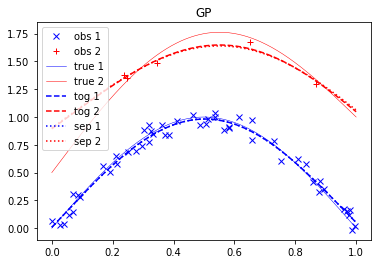

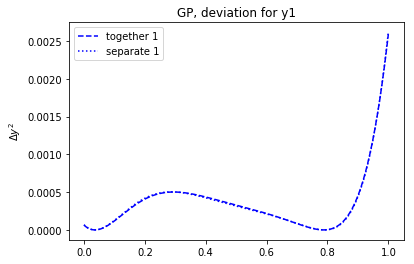

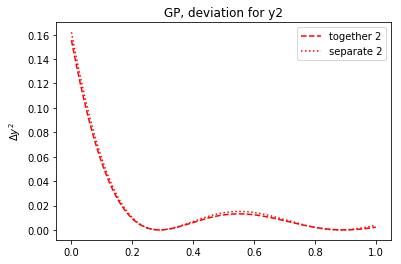

In [6]:
plt.figure()
plt.title('GP')
plt.plot(x1, y1, 'bx', label='obs 1')
plt.plot(x2, y2, 'r+', label='obs 2')
plt.plot(x_, f1(x_), 'b-', lw=0.5, label='true 1')
plt.plot(x_, f2(x_), 'r-', lw=0.5, label='true 2')
plt.plot(x_, y1_gp_together, 'b--', label='tog 1')
plt.plot(x_, y2_gp_together, 'r--', label='tog 2')
plt.plot(x_, y_gp_sep[:,0], 'b:', label='sep 1')
plt.plot(x_, y_gp_sep[:,1], 'r:', label='sep 2')
plt.legend()

plt.figure()
plt.title('GP, deviation for y1')
plt.ylabel(r'$\Delta y^2$')
plt.plot(x_, np.square(f1(x_) - y1_gp_together), 'b--', label='together 1')
plt.plot(x_, np.square(f1(x_) - y_gp_sep[:,0]), 'b:', label='separate 1')
plt.legend()

plt.figure()
plt.title('GP, deviation for y2')
plt.ylabel(r'$\Delta y^2$')
plt.plot(x_, np.square(f2(x_) - y2_gp_together), 'r--', label='together 2')
plt.plot(x_, np.square(f2(x_) - y_gp_sep[:,1]), 'r:', label='separate 2')
plt.legend()

# NN

## Function

In [7]:
import tensorflow as tf

def predict(x, y, w=None):
    feature_columns = [tf.feature_column.numeric_column('x', shape=[x.ndim])]
    if w is None:
        w = np.ones_like(y)
    weight_column = tf.feature_column.numeric_column('w', shape=[w.ndim])
    if y.ndim > 1:
        label_dimension = y.shape[1]
    else:
        label_dimension = 1
    r = tf.contrib.learn.DNNRegressor(
        feature_columns=feature_columns,
        hidden_units=[5, 10, 20, 50, 50, 20, 10, 10],
        activation_fn=tf.nn.tanh,
        label_dimension=label_dimension,
        weight_column_name='w',
    )
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
          x={'x': x, 'w': w},
          y=y,
          num_epochs=None,
          shuffle=True
    )
    r.fit(input_fn=train_input_fn, steps=2000)
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
          x={'x': x_},
          num_epochs=1,
          shuffle=False
    )
    y_ = np.stack(tuple(r.predict(input_fn=test_input_fn)), 0)
    return y_

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Train separatly

In [8]:
y1_sep = predict(x1, y1)
y2_sep = predict(x2, y2)
y_sep = np.stack([y1_sep, y2_sep], 1)

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1275c3d30>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/1d/

INFO:tensorflow:loss = 0.0003031409, step = 1501 (0.333 sec)
INFO:tensorflow:global_step/sec: 459.684
INFO:tensorflow:loss = 0.00017836224, step = 1601 (0.211 sec)
INFO:tensorflow:global_step/sec: 529.855
INFO:tensorflow:loss = 0.00015263908, step = 1701 (0.192 sec)
INFO:tensorflow:global_step/sec: 549.967
INFO:tensorflow:loss = 0.00017064181, step = 1801 (0.181 sec)
INFO:tensorflow:global_step/sec: 536.516
INFO:tensorflow:loss = 0.0001433879, step = 1901 (0.188 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /var/folders/1d/bl0ng6jd7lq3p4j344gc98k00000gn/T/tmprglfg33a/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00019121775.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1d/bl0ng6jd7lq3p4j344gc98k00000gn/T/tmprglfg33a/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


## Train together

In [9]:
y = np.block([
    [y1.reshape(-1,1), np.zeros((y1.shape[0],1))],
    [np.zeros((y2.shape[0],1)), y2.reshape(-1,1)]
])
x = np.hstack((x1, x2))
w = np.block([
    [np.ones((y1.shape[0],1)), np.zeros((y1.shape[0],1))],
    [np.zeros((y2.shape[0],1)), np.ones((y2.shape[0],1))]
])
y_together = predict(x, y, w)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x127acba20>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/var/folders/1d/bl0ng6jd7lq3p4j344gc98k00000gn/T/tmpo9bl3rp2'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/1d/bl0ng6jd7lq3p4j344gc98k00000g

## Plot

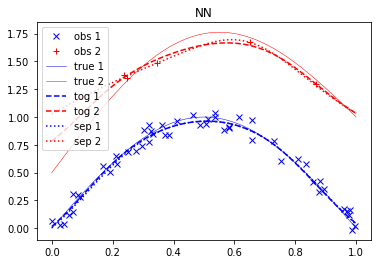

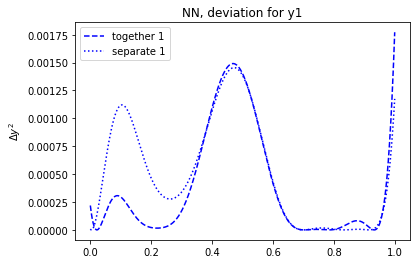

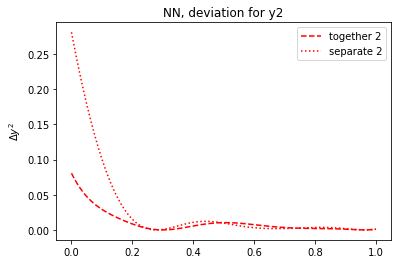

In [10]:
plt.figure()
plt.title('NN')
plt.plot(x1, y1, 'bx', label='obs 1')
plt.plot(x2, y2, 'r+', label='obs 2')
plt.plot(x_, f1(x_), 'b-', lw=0.5, label='true 1')
plt.plot(x_, f2(x_), 'r-', lw=0.5, label='true 2')
plt.plot(x_, y_together[:,0], 'b--', label='tog 1')
plt.plot(x_, y_together[:,1], 'r--', label='tog 2')
plt.plot(x_, y_sep[:,0], 'b:', label='sep 1')
plt.plot(x_, y_sep[:,1], 'r:', label='sep 2')
plt.legend()

plt.figure()
plt.title('NN, deviation for y1')
plt.ylabel(r'$\Delta y^2$')
plt.plot(x_, np.square(f1(x_) - y_together[:,0]), 'b--', label='together 1')
plt.plot(x_, np.square(f1(x_) - y_sep[:,0]), 'b:', label='separate 1')
plt.legend()

plt.figure()
plt.title('NN, deviation for y2')
plt.ylabel(r'$\Delta y^2$')
plt.plot(x_, np.square(f2(x_) - y_together[:,1]), 'r--', label='together 2')
plt.plot(x_, np.square(f2(x_) - y_sep[:,1]), 'r:', label='separate 2')
plt.legend()